# Part 1: Wrangling

In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# toggle off row display limit
pd.set_option("display.max_rows", None)

In [3]:
# toggle on row display limit
pd.reset_option("display.max_rows")

### Problem 1

In [4]:
sqlite_file = "lahman2014.sqlite"
conn = sql.connect(sqlite_file)

In [5]:
# sql code to retrieve the data of interest from the database
teams_query = """
                SELECT 
                    A.yearID, 
                    A.teamID, 
                    franchID,   
                    W, 
                    G, 
                    100*CAST(W AS float)/CAST(G AS float) AS winPercent,
                    payroll
                FROM 
                    Teams A
                INNER JOIN 
                    (SELECT yearID, teamID, SUM(salary) AS payroll FROM Salaries GROUP BY yearID, teamID) B 
                ON
                    A.yearID = B.yearID AND A.teamId = B.teamId
            """

# runs the sql code and stores the data in a dataframe
teams = pd.read_sql(teams_query, conn)

In [6]:
teams

,yearID,teamID,franchID,W,G,winPercent,payroll
0,1985,ATL,ATL,66,162,40.740741,14807000.0
1,1985,BAL,BAL,83,161,51.552795,11560712.0
2,1985,BOS,BOS,81,163,49.693252,10897560.0
3,1985,CAL,ANA,90,162,55.555556,14427894.0
4,1985,CHA,CHW,85,163,52.147239,9846178.0
...,...,...,...,...,...,...,...
853,2014,SLN,STL,90,162,55.555556,120693000.0
854,2014,TBA,TBD,77,162,47.530864,72689100.0
855,2014,TEX,TEX,67,162,41.358025,112255059.0
856,2014,TOR,TOR,83,162,51.234568,109920100.0


I used the `read_sql()` method in Pandas to extract data from the SQLite database and put it into a Pandas database. In my SQL query, I used the `GROUP BY` statement to sum all of the salaries for each team/year combination in the Salaries table, and then used the `INNER JOIN` statement to combine the resulting table with selected data from the Teams table.

As a result of using `INNER JOIN`, team/year combinations that existed in one table but not the other (missing data) were not included in the final table. Therefore the final table does not have any data from before 1985, which is the earliest year of recorded data in the Salaries table.

For both of these tables, when the row exists, all variables in the row seem to exist.

# Part 2: Exploratory Data Analysis

## Payroll Distribution

### Problem 2

array([<AxesSubplot:title={'center':'payroll'}>], dtype=object)

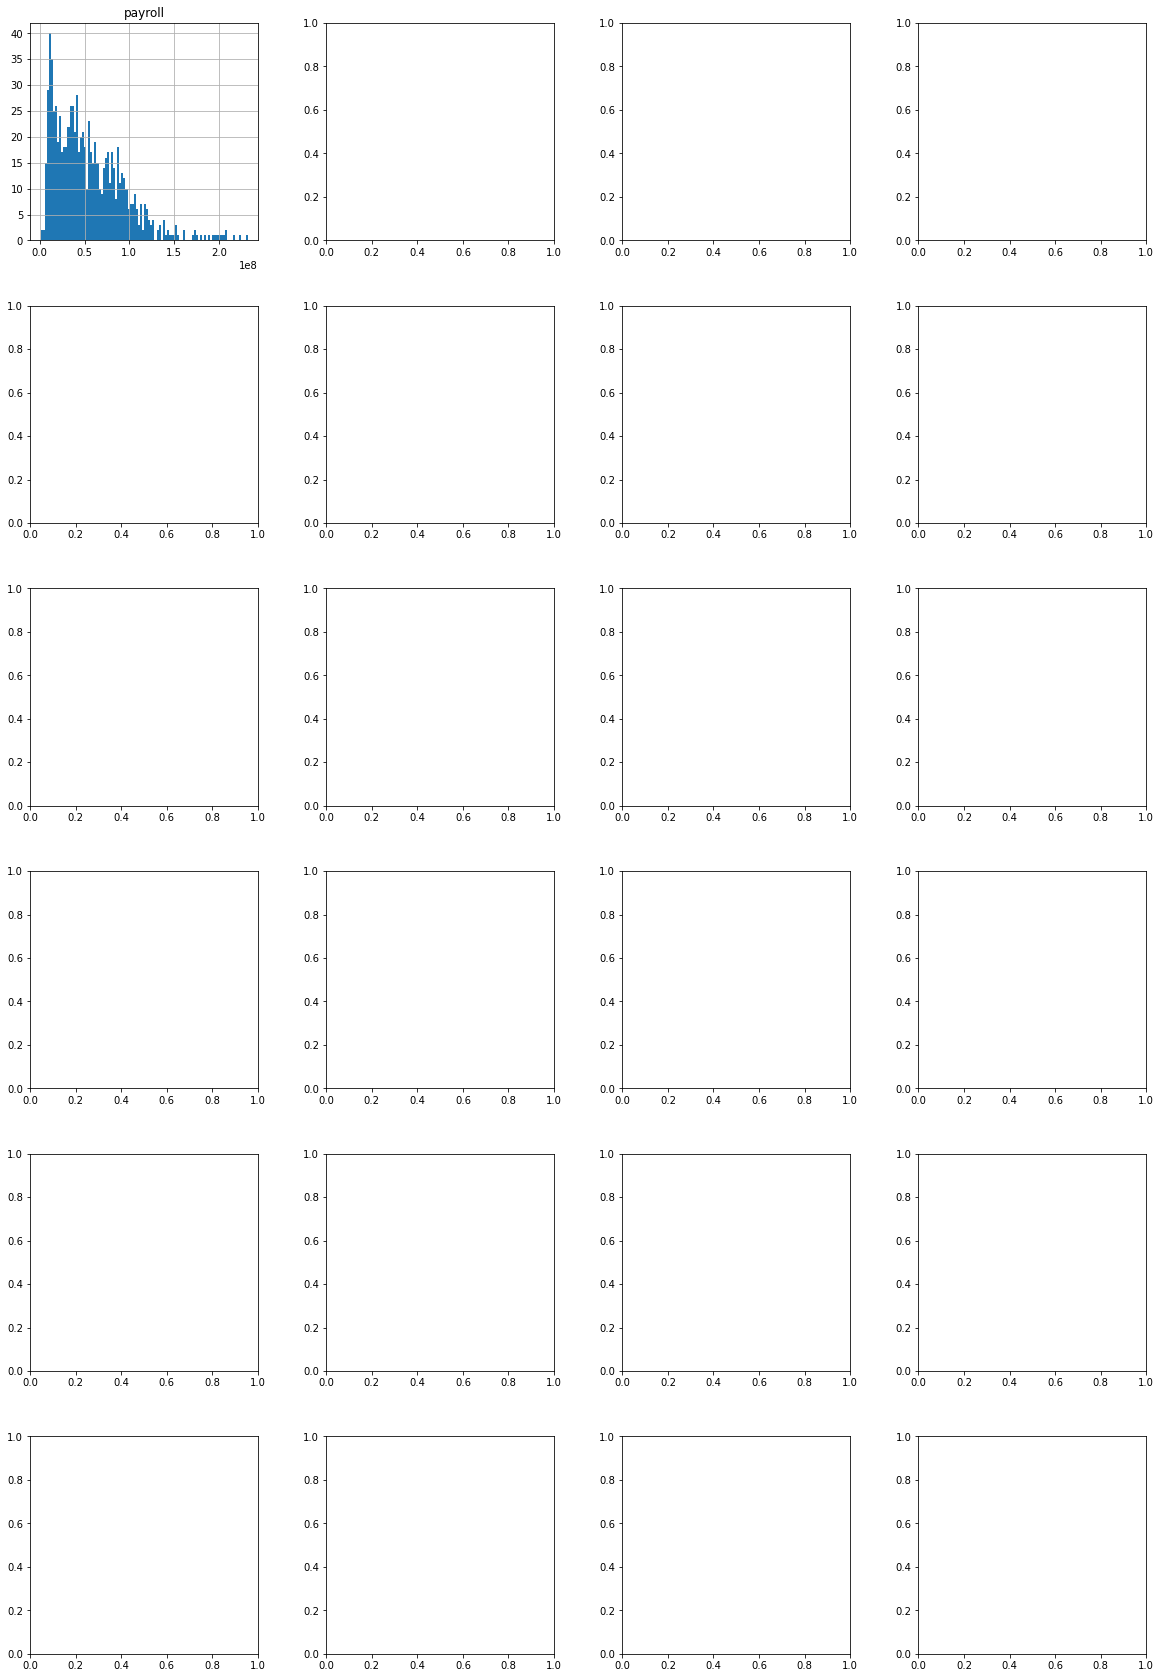

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))
teams.hist(column="payroll", bins=100, ax=axes[0][0])

## Correlation between payroll and winning percentage

### Problem 4

In [8]:
# sets yearID as the index and puts the payroll column in a series
payrolls = teams.set_index("yearID").iloc[:, 5]

In [9]:
payrolls

yearID
1985     14807000.0
1985     11560712.0
1985     10897560.0
1985     14427894.0
1985      9846178.0
           ...     
2014    120693000.0
2014     72689100.0
2014    112255059.0
2014    109920100.0
2014    131983680.0
Name: payroll, Length: 858, dtype: float64

In [10]:
bins = pd.cut(x=payrolls, bins=5, labels=["A", "B", "C", "D", "E"], retbins=True)

In [11]:
bins

(yearID
 1985    A
 1985    A
 1985    A
 1985    A
 1985    A
        ..
 2014    C
 2014    B
 2014    C
 2014    C
 2014    C
 Name: payroll, Length: 858, dtype: category
 Categories (5, object): ['A' < 'B' < 'C' < 'D' < 'E'],
 array([6.48901114e+05, 4.70997772e+07, 9.33195544e+07, 1.39539332e+08,
        1.85759109e+08, 2.31978886e+08]))

In [12]:
teams.iloc[:, 0]

0      1985
1      1985
2      1985
3      1985
4      1985
       ... 
853    2014
854    2014
855    2014
856    2014
857    2014
Name: yearID, Length: 858, dtype: int64

In [13]:
# puts each index from the teams dataframe in a bin based on its year
years = teams.iloc[:, 0].rename("bin")
bins = pd.cut(x=years, bins=[1990, 1995, 2000, 2005, 2010, 2015], labels=["A", "B", "C", "D", "E"], right=False)

# add a bin column to the teams dataframe
means = teams.drop(teams.columns.difference(["franchID", "winPercent", "payroll"]), 1).join(bins)

In [14]:
means

,franchID,winPercent,payroll,bin
0,ATL,40.740741,14807000.0,NaN
1,BAL,51.552795,11560712.0,NaN
2,BOS,49.693252,10897560.0,NaN
3,ANA,55.555556,14427894.0,NaN
4,CHW,52.147239,9846178.0,NaN
...,...,...,...,...
853,STL,55.555556,120693000.0,E
854,TBD,47.530864,72689100.0,E
855,TEX,41.358025,112255059.0,E
856,TOR,51.234568,109920100.0,E


In [15]:
means = means.groupby(by=["bin", "franchID"]).mean()

In [16]:
means

# some bins have NaN because the franchises don't exist in that time period, 
# for example the Diamonbacks (ARI) weren't founded until 1998, so they're NaN in bin A (1990-1994)

winPercent      payroll
bin franchID                         
A   ANA        45.704777   28654777.4
    ARI              NaN          NaN
    ATL        56.497726   31721852.8
    BAL        50.444080   23785204.0
    BOS        49.514761   34863216.8
...                  ...          ...
E   STL        55.679012  104445659.0
    TBD        54.992047   60558982.8
    TEX        53.881694   98567688.2
    TOR        48.888889   87203840.0
    WSN        53.024308   90359804.2

[150 rows x 2 columns]

<AxesSubplot:title={'center':'Winning Percentage vs. Payroll (2010-2014)'}, xlabel='payroll', ylabel='winPercent'>

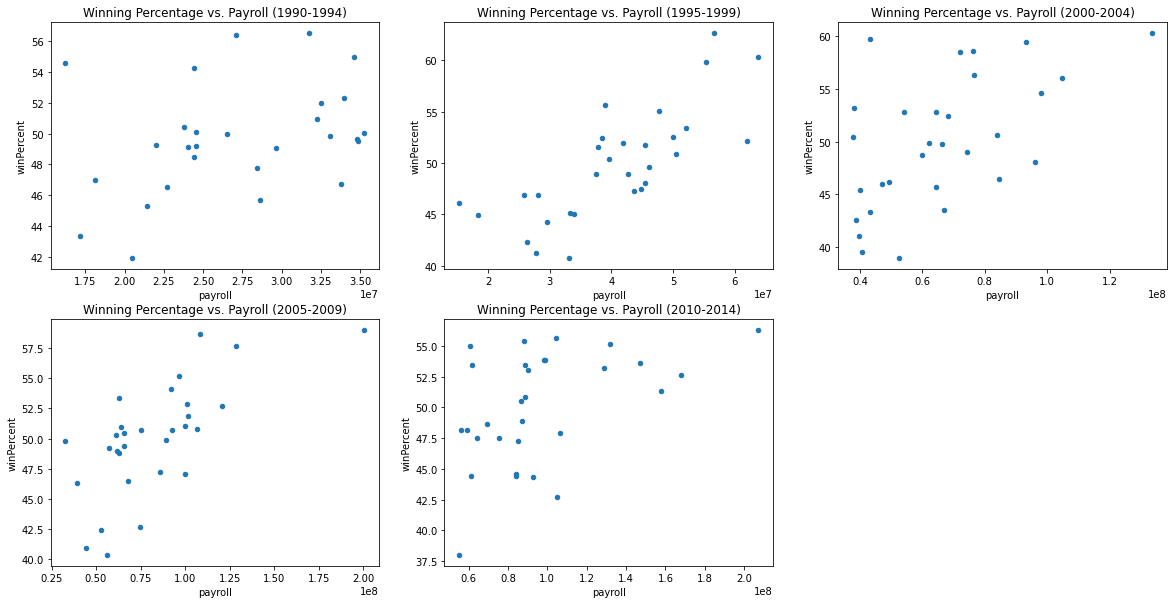

In [27]:
# creates 5 subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.delaxes(axes[1][2])

means.loc["A"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][0], title="Winning Percentage vs. Payroll (1990-1994)")
means.loc["B"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][1], title="Winning Percentage vs. Payroll (1995-1999)")
means.loc["C"].plot.scatter(x="payroll", y="winPercent", ax=axes[0][2], title="Winning Percentage vs. Payroll (2000-2004)")
means.loc["D"].plot.scatter(x="payroll", y="winPercent", ax=axes[1][0], title="Winning Percentage vs. Payroll (2005-2009)")
means.loc["E"].plot.scatter(x="payroll", y="winPercent", ax=axes[1][1], title="Winning Percentage vs. Payroll (2010-2014)")